In [3]:
!pip install matplotlib

  Using cached matplotlib-3.9.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached pillow-10.4.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
Using cached matplotlib-3.9.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
Using cached contourpy-1.2.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (309 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.53.1-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
block_list = [4, 8, 16, 32]

In [4]:
def get_l1_miss(file_path):
    try:
        with open(file_path, 'r') as f:
            d = json.load(f)
    except:
        raise Exception(f"Error in `get_l1_miss` -> Can't open the file path: {file_path}")

    d = d['threads']['0']['regions']['0']
    miss:float = float(d['PAPI_L1_DCM'])/float(d['PAPI_L1_DCA'])
    return miss
    
def get_l2_miss(file_path):
    try:
        with open(file_path, 'r') as f:
            d = json.load(f)
    except:
        raise Exception(f"Error in `get_l2_miss` -> Can't open the file path: {file_path}")
    d = d['threads']['0']['regions']['0']
    miss:float = float(d['PAPI_L2_DCM'])/(float(d['PAPI_L2_DCM']) + float(d['PAPI_L2_DCH']))
    return miss
   

In [5]:
import os

bf_avg_time:float = 37545263.40

bf_l1 = 0
bf_l2 = 0

for file in os.listdir("papi_outputs/papi_bf/papi_hl_output/"):
    bf_l1 += get_l1_miss("papi_outputs/papi_bf/papi_hl_output/" + file)
    bf_l2 += get_l2_miss("papi_outputs/papi_bf/papi_hl_output/" + file)


bf_l1 /= 5
bf_l2 /= 5

print(f"bf takes time: {bf_avg_time} with l1_miss: {bf_l1} & l2_miss: {bf_l2}")

bf takes time: 37545263.4 with l1_miss: 0.618134545024191 & l2_miss: 0.49445465904784874


In [29]:
# fetch miss percentage for all block-size combinations

catch_misses = {}
for i in block_list:
    for j in block_list:
        for k in block_list:
            dir_path = f"papi_outputs/papi_{i}_{j}_{k}/"
            l1_miss = 0.00000
            l2_miss = 0.00000
            for dir_ in os.listdir(dir_path):
                for file in os.listdir(dir_path + dir_):
                    l1_miss += get_l1_miss(dir_path + dir_ + "/"+file)
                    l2_miss += get_l2_miss(dir_path + dir_ + "/"+file)

            l1_miss = l1_miss/5
            l2_miss = l2_miss/5

            temp = {}
            temp['l1_miss%'] = l1_miss
            temp['l2_miss%'] = l2_miss

            catch_misses[f"{i}_{j}_{k}"] = temp



In [33]:
df = pd.DataFrame(columns = ['Block_A','Block_B', 'BLOCK_C', 'Speed-Up'])
df

,Block_A,Block_B,BLOCK_C,Speed-Up


In [37]:
df = pd.DataFrame(columns = ['Block_A','Block_B', 'BLOCK_C', 'Speed-Up'])

for i in block_list:
    for j in block_list:
        for k in block_list:
            id = f"{i}_{j}_{k}"
            speed = (bf_avg_time/1000000)/catch_misses[id]['Average_Time']
            new_row = [str(i),str(j),str(k),speed]
            df.loc[len(df)] = new_row
            # df = pd.concat([df, pd.DataFrame([new_row])], axis = 0, ignore_index = True)

df

,Block_A,Block_B,BLOCK_C,Speed-Up
0,4,4,4,5.211859
1,4,4,8,4.140842
2,4,4,16,2.356473
3,4,4,32,1.785256
4,4,8,4,6.531332
...,...,...,...,...
59,32,16,32,1.981173
60,32,32,4,8.449973
61,32,32,8,6.274907
62,32,32,16,2.705932


In [38]:
df.to_csv('speed-up.csv', index = False)

In [31]:
for id in range(len(df)):
    i = df.iloc[id]['BLOCKi']
    j = df.iloc[id]['BLOCKj']
    k = df.iloc[id]['BLOCKk']

    catch_misses[f"{int(i)}_{int(j)}_{int(k)}"]['Average_Time'] = df.iloc[id]['AverageTime']/1000000

catch_misses

{'4_4_4': {'l1_miss%': 0.0,
  'l2_miss%': 0.0,
  'Average_Time': np.float64(7.2577206)},
 '4_4_8': {'l1_miss%': 0.0,
  'l2_miss%': 0.0,
  'Average_Time': np.float64(9.304835800000001)},
 '4_4_16': {'l1_miss%': 0.0,
  'l2_miss%': 0.0,
  'Average_Time': np.float64(16.0760436)},
 '4_4_32': {'l1_miss%': 0.0,
  'l2_miss%': 0.0,
  'Average_Time': np.float64(21.576348600000003)},
 '4_8_4': {'l1_miss%': 0.0,
  'l2_miss%': 0.0,
  'Average_Time': np.float64(5.9546806)},
 '4_8_8': {'l1_miss%': 0.0,
  'l2_miss%': 0.0,
  'Average_Time': np.float64(7.1199308)},
 '4_8_16': {'l1_miss%': 0.0,
  'l2_miss%': 0.0,
  'Average_Time': np.float64(14.445551199999999)},
 '4_8_32': {'l1_miss%': 0.0,
  'l2_miss%': 0.0,
  'Average_Time': np.float64(20.3045814)},
 '4_16_4': {'l1_miss%': 0.0,
  'l2_miss%': 0.0,
  'Average_Time': np.float64(5.4390168)},
 '4_16_8': {'l1_miss%': 0.0,
  'l2_miss%': 0.0,
  'Average_Time': np.float64(6.560571)},
 '4_16_16': {'l1_miss%': 0.0,
  'l2_miss%': 0.0,
  'Average_Time': np.float64

In [6]:
import json
with open("miss_record.json",'r') as f:
    # json.dump(catch_misses, f, indent = 4)
    catch_misses = json.load(f)

# catch_misses

In [7]:
l1 = []
time = []
l2 = []
B = []
for i in block_list:
    for j in block_list:
        for k in block_list:
            id = f"{i}_{j}_{k}"
            B.append(j)
            l1.append(catch_misses[id]['l1_miss%'])
            l2.append(catch_misses[id]['l2_miss%'])
            time.append(catch_misses[id]['Average_Time'])

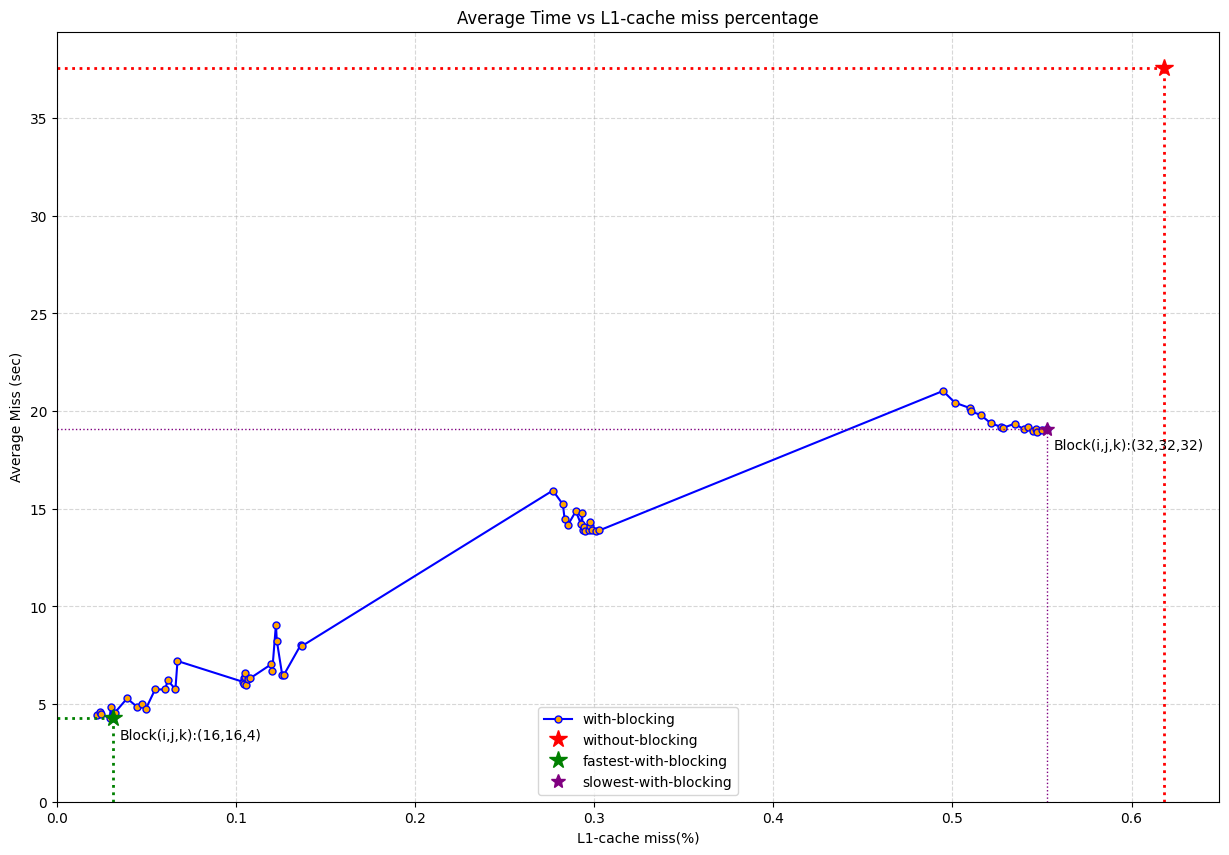

In [20]:
import numpy as np
X = np.array(l1)
Y = np.array(time)
sorted_indices = np.argsort(X)
X_sorted = X[sorted_indices]
Y_sorted = Y[sorted_indices]

# Create the plot
plt.figure(figsize=(15, 10))
plt.plot(X_sorted, Y_sorted, '-o', color='blue', markersize=5, markerfacecolor='orange', label='with-blocking')

# bf points
x_0,y_0 = bf_l1, bf_avg_time/1000000

# Add dotted vertical and horizontal lines
# plt.axvline(x=x_0, color='red', linestyle=':', linewidth=2)
# plt.axhline(y=y_0, color='red', linestyle=':', linewidth=2)
plt.plot([x_0, x_0], [0, y_0], color='red', linestyle=':', linewidth=2)
plt.plot([0, x_0], [y_0, y_0], color='red', linestyle=':', linewidth=2)
plt.plot(x_0, y_0, 'r*', markersize= 13, label='without-blocking')
# plt.annotate('Without-Blocking', (x_0, y_0), xytext=(-5, -5), textcoords='offset points', color='red')

x_1,y_1 = catch_misses[block]['l1_miss%'], catch_misses[block]['Average_Time']
plt.plot([x_1, x_1], [0, y_1], color='green', linestyle=':', linewidth=2)
plt.plot([0, x_1], [y_1, y_1], color='green', linestyle=':', linewidth=2)
plt.plot(x_1,y_1, 'g*', markersize= 13, label='fastest-with-blocking' )
plt.annotate('Block(i,j,k):(16,16,4)', (x_1, y_1), xytext=(5, -15), textcoords='offset points', color='black')

x_2,y_2 = catch_misses[block1]['l1_miss%'], catch_misses[block1]['Average_Time']
plt.plot([x_2, x_2], [0, y_2], color='purple', linestyle=':', linewidth=1)
plt.plot([0, x_2], [y_2, y_2], color='purple', linestyle=':', linewidth=1)
plt.plot(x_2,y_2, '*', color='purple', markersize= 10, label='slowest-with-blocking' )
plt.annotate('Block(i,j,k):(32,32,32)', (x_2, y_2), xytext=(5, -15), textcoords='offset points', color='black')

plt.title('Average Time vs L1-cache miss percentage')
plt.xlabel('L1-cache miss(%)')
plt.ylabel('Average Miss (sec)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlim(left=0)
plt.ylim(bottom=0)

plt.legend(loc='best')
# Show the plot
plt.savefig('cache_miss_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [16]:
mx:float = 0
block1:str = ""

for k in catch_misses.keys():
    if catch_misses[k]['Average_Time'] > mn:
        mx = catch_misses[k]['Average_Time']
        block1 = k

print(f"{block1} has time: {mx} us")
print(catch_misses[block1])

32_32_32 has time: 19.0819858 us
{'l1_miss%': 0.5526423953392421, 'l2_miss%': 0.0022936322700039258, 'Average_Time': 19.0819858}


In [39]:
print(catch_misses[block])

{'l1_miss%': 0.03115945392100015, 'l2_miss%': 0.016864206957069545, 'Average_Time': 4.28131}
